In [ ]:
!pip install secml
!pip install torch
!pip install foolbox

**Evasion Attacks aganist ML models.**

Attacks can be targeted or untargeted,
in targetted attacker aims to misclassify into a specific class. Untargeted attacks misclassify something into any other class.


In [ ]:
RANDOM_STATE = 999
n_features = 2
n_samples = 1250
centers =[[-2,0], [2,-2], [2,2]]
cluster_std = 0.8
n_classes = len(centers)

#load data
from secml.data.loader import CDLRandomBlobs
dataset = CDLRandomBlobs(n_features=n_features,
                         n_samples=n_samples,
                         centers=centers,
                         cluster_std=cluster_std,
                         random_state=RANDOM_STATE).load()

n_tr = 1000 #training samples
n_ts = 250 #test samples

#splitting data
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(train_size=n_tr, test_size=n_ts, random_state=RANDOM_STATE)
tr, ts = splitter.split(dataset)


#normlaize data
from secml.ml.features import CNormalizerMinMax

nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)





In [ ]:
tr.X

CArray(1000, 2)(dense: [[0.637186 0.628997] [0.638994 0.288309] [0.663107 0.825976] ... [0.692256 0.229302] [0.621074 0.722742] [0.660583 0.782492]])

In [ ]:
tr.Y

CArray(1000,)(dense: [2 1 2 ... 1 2 2])

In [ ]:
from secml.ml.classifiers import CClassifierSVM
from secml.ml.kernels import CKernelRBF
from secml.ml.peval.metrics import CMetricAccuracy

#model
kernel = CKernelRBF(gamma =1.0)

#secure classifer wrapper
clf1 = CClassifierSVM(kernel=kernel, C=1.0)

#train classifer on our data
clf1.fit(tr.X, tr.Y)

#predictions on test
y_pred = clf1.predict(ts.X)

#accuracy
metric = CMetricAccuracy()
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print(f"Accuracy: {acc:.2%}")


Accuracy: 99.60%


In [ ]:
%matplotlib inline
from secml.figure import CFigure

fig = CFigure()
fig.sp.plot_ds(tr) #prints points
fig.sp.plot_decision_regions(clf1, plot_background=True, n_grid_points=200)
fig.show()


Evasion attack on a model

In [ ]:
from secml.adv.attacks.evasion import CFoolboxPGDL2

index = 0
point = ts[index, :]
x0, y0 = point.X, point.Y

steps = 200 #number of iterations
eps = 0.3 #max pertubation in l2
alpha = 0.1 #step size for each iteration
y_target = None #untargeted since its none
#input space
lb = tr.X.min()
ub = tr.X.max()

pgd_attack = CFoolboxPGDL2(clf1, y_target,
                           lb=lb, ub=ub, epsilons = eps,
                           abs_stepsize = alpha, steps=steps, random_start=42)

y_pred, _, adv_ds_pgd, _ = pgd_attack.run(x0, y0)

print(f"Original class: {y0.item()}")
#predicted class of adversial
print(f"Predicted class: {y_pred.item()}")

Original class: 0
Predicted class: 2


In [ ]:
adv_ds_pgd #adversial dataset genrated by attack,
# basically the path the fuckn point got pushed

CDataset{'X': CArray(1, 2)(dense: [[0.614941 0.83629 ]]), 'Y': CArray(1,)(dense: [0]), 'header': None}

In [ ]:
x_adv = adv_ds_pgd.X
x_adv

CArray(1, 2)(dense: [[0.614941 0.83629 ]])

Lets Visualize the attack

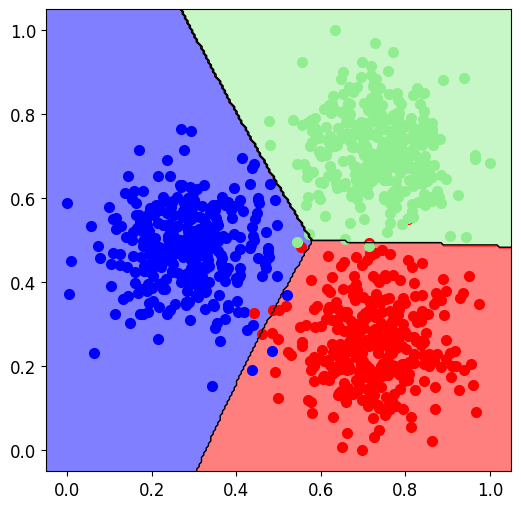

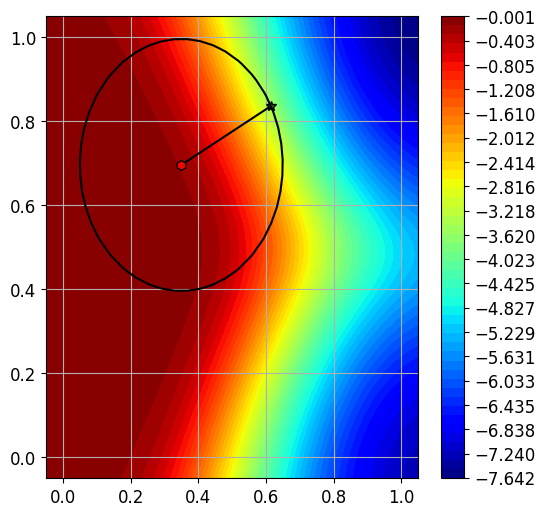

In [ ]:
%matplotlib inline

from secml.figure import CFigure
from secml.optim.constraints import CConstraintL2, CConstraintBox

fig = CFigure()
#objectve give you the grid, with colours with their classes
fig.sp.plot_fun(pgd_attack.objective_function, n_grid_points=200)

#draws the fuckn circle box, to show where max perturbation is
constraint = CConstraintL2(center = x0, radius = eps)
#point path
#have to all this shit to put into plotpath
path = [x0.tondarray().ravel(), x_adv.tondarray().ravel()]
fig.sp.plot_path(path) # plot the path
#draws the circle
fig.sp.plot_constraint(constraint)

fig.show()

1. Load the MNIST dataset and create a Neural Network with PyTorch.
2. Train the model on the MNIST dataset with SecML.
3. Lanch the same attack that is been implemented PGDL2.
4. Evaluate the accuracy

In [ ]:
from torch import nn
import torch

class Net(nn.Module):
  #dataset for a MNIST 10 classes
  def __init__(self): #specifices the architecture
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1,10,kernel_size = 5)
    self.conv2 = nn.Conv2d(10,20,kernel_size = 5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320,50)
    self.fc2 = nn.Linear(50,10)

  def forward(self,x): #passes input through all the defined layers with activation functions
    x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
    x = torch.relu(torch.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1,320)
    x = torch.relu(self.fc1(x))
    return self.fc2(x)

n_tr = 30  # number of training samples
n_ts = 10 # number of testing samples

from secml.data.loader import CDataLoaderMNIST

loader = CDataLoaderMNIST()
tr = loader.load('training')
ts = loader.load('testing', num_samples=n_ts)

# normalize the data
tr.X = tr.X / 255
ts.X = ts.X / 255

import torch.optim as optim

net = Net() #make the neural  network
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)
loss_function = nn.CrossEntropyLoss()

#All of these are pass into the secml wrapper for Pytorch models and train our network
from secml.ml.classifiers import CClassifierPyTorch
clf = CClassifierPyTorch(model = net,
                        loss= loss_function,
                        optimizer= optimizer,
                        epochs = 3,
                        batch_size = 20,
                        input_shape = (1, 28,28),
                        random_state =0)

clf.fit(tr.X, tr.Y)




Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()
preds = clf.predict(ts.X)
accuracy = metric.performance_score(y_true=ts.Y, y_pred = preds)
print({accuracy * 100})

{100.0}


In [ ]:
#attack
from secml.adv.attacks.evasion import CFoolboxPGDLinf
y_target = None # untarget
lb, ub = 0.0, 1.0
eps = 0.3 # will  be changed by the secirtuy evalution class
alpha = 0.05
steps = 100

attack = CFoolboxPGDLinf(clf, y_target,
                         lb=lb, ub=ub,
                         epsilons=eps,
                         abs_stepsize=alpha,
                         steps=steps,
                         random_start=False)




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from secml.array import CArray
from secml.adv.seceval import CSecEval

epsilon_vals = CArray.linspace(0,stop=0.5, num=10) # chaning the epilson
sec_eval = CSecEval(attack = attack, param_name='epsilon', param_values=epsilon_vals)
sec_eval.run_sec_eval(ts)


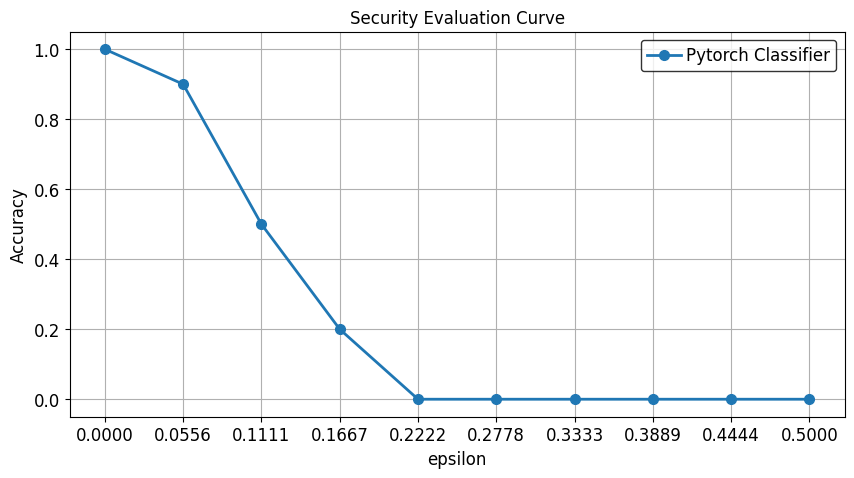

In [ ]:
%matplotlib inline
from secml.figure import CFigure
fig = CFigure(height=5, width=10)
fig.sp.plot_sec_eval(sec_eval.sec_eval_data, marker = 'o', label = 'Pytorch Classifier')